In [1]:
# !pip install pandas
# !pip install numpy
# !pip install pyarrow
# !pip install seaborn 
# !pip install matplotlib

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, root_mean_squared_error

### Q1. Downloading the data

In [2]:
jan_df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet")
jan_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [3]:
feb_df = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet")
feb_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,4.4,3.50,0.5,0.0,0.0,1.0,9.40,2.5,0.00
1,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,-3.0,-1.00,-0.5,0.0,0.0,-1.0,-5.50,0.0,0.00
2,2,2023-02-01 00:35:16,2023-02-01 00:35:30,1.0,0.00,1.0,N,71,71,4,3.0,1.00,0.5,0.0,0.0,1.0,5.50,0.0,0.00
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,70.9,2.25,0.5,0.0,0.0,1.0,74.65,0.0,1.25
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,17.0,1.00,0.5,3.3,0.0,1.0,25.30,2.5,0.00


#### Read the data for January. How many columns are there?

16
17
18
19


In [4]:
len(jan_df.columns)

19

### Q2. Computing Duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?

32.59
42.59
52.59
62.59

In [5]:
jan_df["duration"] = jan_df.tpep_dropoff_datetime - jan_df.tpep_pickup_datetime
jan_df['duration'] = jan_df.duration.apply(lambda x: x.total_seconds()/60)
jan_df.duration.std()

42.59435124195458

### Q3. Dropping Outliers

Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

90%
92%
95%
98%

<Axes: xlabel='duration', ylabel='Density'>

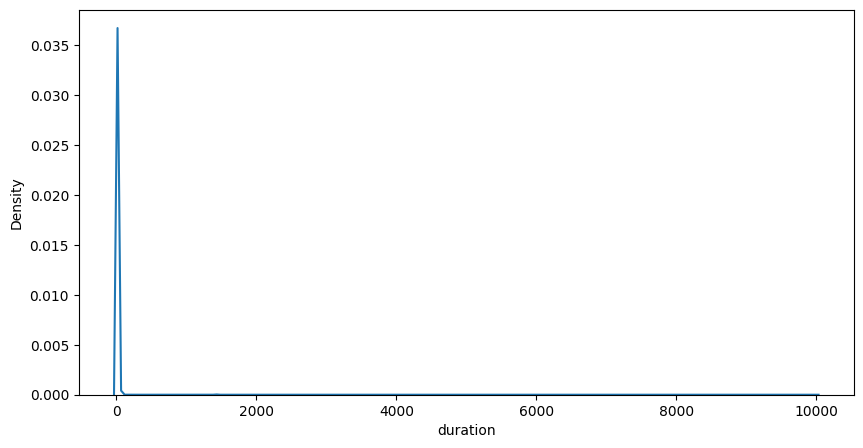

In [6]:
plt.figure(figsize=(10,5))
sns.kdeplot(jan_df.duration)

In [7]:
jan_df_wo_outliers = jan_df[(jan_df.duration >= 1) & (jan_df.duration <= 60)]
len(jan_df_wo_outliers) / len(jan_df) * 100

98.1220282212598

<Axes: xlabel='duration', ylabel='Density'>

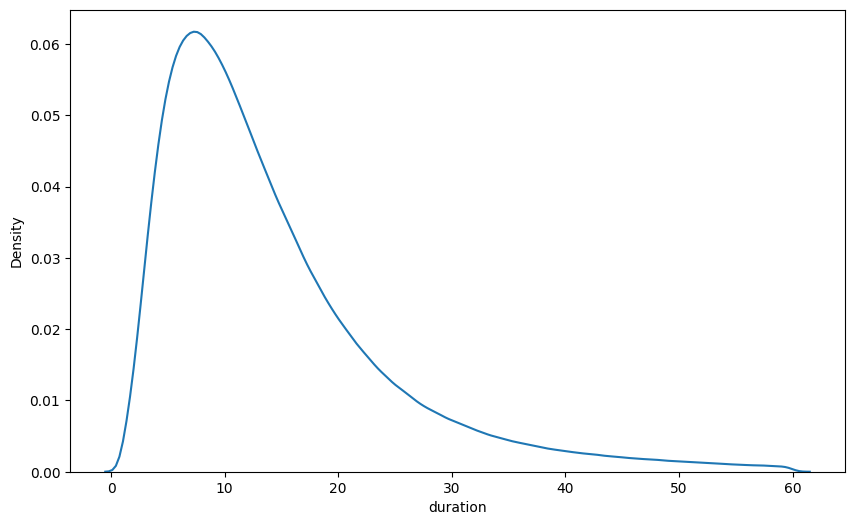

In [8]:
plt.figure(figsize=(10, 6))
sns.kdeplot(jan_df_wo_outliers.duration)

### Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
Fit a dictionary vectorizer
Get a feature matrix from it
What's the dimensionality of this matrix (number of columns)?

2
155
345
515
715

In [10]:
categorical = ['PULocationID', 'DOLocationID']
jan_df_wo_outliers.loc[:,categorical] = jan_df_wo_outliers.loc[:,categorical].astype(str)

In [11]:
jan_cat_dict = jan_df_wo_outliers[categorical].to_dict(orient='records')

In [12]:
vectorizer = DictVectorizer()
X_train_jan = vectorizer.fit_transform(jan_cat_dict)

In [13]:
X_train_jan.shape

(3009173, 515)

### Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.

Train a plain linear regression model with default parameters, where duration is the response variable
Calculate the RMSE of the model on the training data
What's the RMSE on train?

3.64
7.64
11.64
16.64

In [14]:
lr = LinearRegression()

lr.fit(X_train_jan, jan_df_wo_outliers['duration'])

LinearRegression()

In [15]:
y_pred = lr.predict(X_train_jan)
root_mean_squared_error(jan_df_wo_outliers['duration'], y_pred)

7.649261932106969

### Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023).

What's the RMSE on validation?

3.81
7.81
11.81
16.81

In [16]:
def preprocess(df):

    df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df['duration'] = df.duration.apply(lambda x: x.total_seconds()/60)
    
    df_wo_outliers = df[(df.duration >= 1) & (df.duration <= 60)]

    return df_wo_outliers

In [17]:
feb_df_wo_outliers = preprocess(feb_df)

In [20]:
def vectorize(df, vectorizer):

    categorical = ['PULocationID', 'DOLocationID']

    df.loc[:,categorical] = df.loc[:,categorical].astype(str)
    cat_dict = df[categorical].to_dict(orient='records')
    
    return vectorizer.transform(cat_dict)

In [21]:
X_val = vectorize(feb_df_wo_outliers, vectorizer)

In [23]:
y_val_pred = lr.predict(X_val)

In [24]:
root_mean_squared_error(feb_df_wo_outliers['duration'], y_val_pred)

7.811818743246608